In [64]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import torch
from torch.utils.data import DataLoader
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network, example_convert_to_torch
from second.protos import pipeline_pb2
from second.utils import config_tool
from second.pytorch.builder.input_reader_builder import DatasetWrapper
from second.data.preprocess import merge_second_batch
from second.data.inference_dataset import InferDataset

## Read Config file

In [3]:
saved_model_path = "/home/robesafe/Javier/Frustum_PointPillars/second/saved_models/frustum_pointpillars_all_12_base/"
config_path = saved_model_path+"pipeline.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
#config_tool.change_detection_range(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Build Network, Target Assigner and Voxel Generator

In [4]:
train_cfg = config.train_config

ckpt_path = saved_model_path+"voxelnet-321600.tckpt"
net = build_network(model_cfg).to(device).eval()
net.load_state_dict(torch.load(ckpt_path))
if train_cfg.enable_mixed_precision:
    net.half()
    print("half inference!")
    net.metrics_to_float()
    net.convert_norm_to_float(net)
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

## Generate Anchors

In [5]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
#anchors = anchors.view(1, -1, 7)

## Read KITTI infos
you can load your custom point cloud.

In [6]:
# info_path = input_cfg.dataset.kitti_info_path
# train_cfg = config.train_config
# root_path = Path(input_cfg.dataset.kitti_root_path)
# with open(info_path, 'rb') as f:
#     infos = pickle.load(f)

## Load Point Cloud, Generate Voxels

In [35]:
id = 3
v_path = "/media/robesafe/SSD_SATA/KITTI_DATASET/training/velodyne/"+'%06d'%id+".bin"
points = np.fromfile(v_path, dtype=np.float32, count=-1).reshape([-1, 4])
dict_voxel = voxel_generator.generate(points, max_voxels=2048)
#voxels, coords, num_points = dict_voxel['voxels'], dict_voxel['coordinates'], dict_voxel['num_points_per_voxel']

coords = np.pad(dict_voxel['coordinates'], ((0, 0), (1, 0)), mode='constant', constant_values=0)
coords = torch.tensor(coords, dtype=torch.int32, device=device)
voxels = torch.tensor(dict_voxel['voxels'], dtype=torch.float32, device=device)
num_voxels = torch.tensor(dict_voxel['voxel_num'], dtype=torch.float32, device=device)
num_points = torch.tensor(dict_voxel['num_points_per_voxel'], dtype=torch.int32, device=device)

## Detection

### Pointcloud after pointcloud

In [7]:
anchors_ = anchors.view(1, -1, 7)
example = {
    "anchors": anchors_,
    "voxels": voxels,
    "num_points": num_points,
    "coordinates": coords,
}
examples = np.array([example, example, example, example])

start = time()
detections = []
for example in examples:
    with torch.no_grad():
        detections += net(example)
print(time()-start)
print(detections)

0.24577927589416504
[{'box3d_lidar': tensor([[-7.5960e+00, -5.6196e-01, -1.6142e+00,  1.7956e+00,  4.4739e+00,
          1.6223e+00, -1.4431e+00],
        [-7.1888e+00,  3.6912e+00, -1.3343e+00,  1.5783e+00,  3.6876e+00,
          1.4489e+00, -1.8386e+00],
        [-3.2799e+00, -3.7651e+00, -1.9508e+00,  1.4922e+00,  3.8497e+00,
          1.4407e+00,  1.9238e+00],
        [-7.4269e+00, -1.2278e+00, -1.7941e+00,  1.7071e+00,  4.3086e+00,
          1.6031e+00, -6.1224e-03],
        [ 7.5262e+00,  9.4770e-01, -1.5302e+00,  1.6106e+00,  3.9179e+00,
          1.4756e+00,  2.9084e+00],
        [ 5.7465e+00, -6.2875e-01, -1.9018e+00,  1.7050e+00,  3.7014e+00,
          1.5740e+00,  1.5617e+00],
        [-7.3149e+00,  2.6318e+00, -1.2909e+00,  8.1435e-01,  1.0371e+00,
          1.6226e+00, -2.6420e+00],
        [-4.8762e+00,  7.7114e-01, -2.1198e+00,  1.7907e+00,  4.1501e+00,
          1.6761e+00,  1.3721e+00],
        [-7.5175e+00,  4.9616e-01, -1.1387e+00,  5.4416e-01,  9.7033e-01,
         

### Batch of pointclouds

In [71]:
anchors_ = anchors.view(-1, 7)
example = {
    "anchors": anchors_.cpu(), # b, x, 7
    "voxels": voxels.cpu(), # b, ...
    "num_points": num_points.cpu(), #b, ...
    "num_voxels": num_voxels.cpu(), #b, ...
    "coordinates": coords.cpu(),
    "type": 'Car',
}
#print(example['anchors'].shape)
examples = np.array([example]*10)
#print(examples.shape)
start_ = time()

dataset = InferDataset(examples)
#dataset = DatasetWrapper(examples)
eval_dataloader = DataLoader(
        dataset,
        batch_size=10,
        shuffle=False,
        pin_memory=False,
        collate_fn=merge_second_batch)

float_dtype = None
if train_cfg.enable_mixed_precision:
    float_dtype = torch.float16
else:
    float_dtype = torch.float32

#net.eval()
#torch.cuda.synchronize()
detections = []
for data in eval_dataloader:
    #print(data['anchors'].shape)
    start = time()
    data = example_convert_to_torch(data, float_dtype)
    with torch.no_grad():
        detections += net(data)
print(start-start_)
print(detections)

0.004794120788574219
[{'box3d_lidar': tensor([[ 7.4066, -1.5732, -0.9737,  1.6202,  3.7200,  1.5267,  1.8423]],
       device='cuda:0'), 'scores': tensor([0.9854], device='cuda:0'), 'label_preds': tensor([0], device='cuda:0'), 'metadata': None}, {'box3d_lidar': tensor([[ 7.4049, -1.5734, -0.9750,  1.6200,  3.7191,  1.5266,  1.8440]],
       device='cuda:0'), 'scores': tensor([0.9853], device='cuda:0'), 'label_preds': tensor([0], device='cuda:0'), 'metadata': None}, {'box3d_lidar': tensor([[ 7.4064, -1.5732, -0.9736,  1.6202,  3.7199,  1.5267,  1.8424]],
       device='cuda:0'), 'scores': tensor([0.9854], device='cuda:0'), 'label_preds': tensor([0], device='cuda:0'), 'metadata': None}, {'box3d_lidar': tensor([[ 7.4060, -1.5732, -0.9737,  1.6203,  3.7195,  1.5266,  1.8426]],
       device='cuda:0'), 'scores': tensor([0.9853], device='cuda:0'), 'label_preds': tensor([0], device='cuda:0'), 'metadata': None}, {'box3d_lidar': tensor([[ 7.4062, -1.5733, -0.9738,  1.6201,  3.7198,  1.5267,  1.

In [47]:
pred['box3d_lidar'][:1]

tensor([[34.8812, -3.1274, -1.2073,  1.6100,  3.9520,  1.4740, -1.6685]],
       device='cuda:0')

In [30]:
pred.keys()

dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata'])

## Simple Vis

In [48]:
boxes_lidar = pred["box3d_lidar"][:1].detach().cpu().numpy()
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, boxes_lidar, [0, 255, 0], 2)

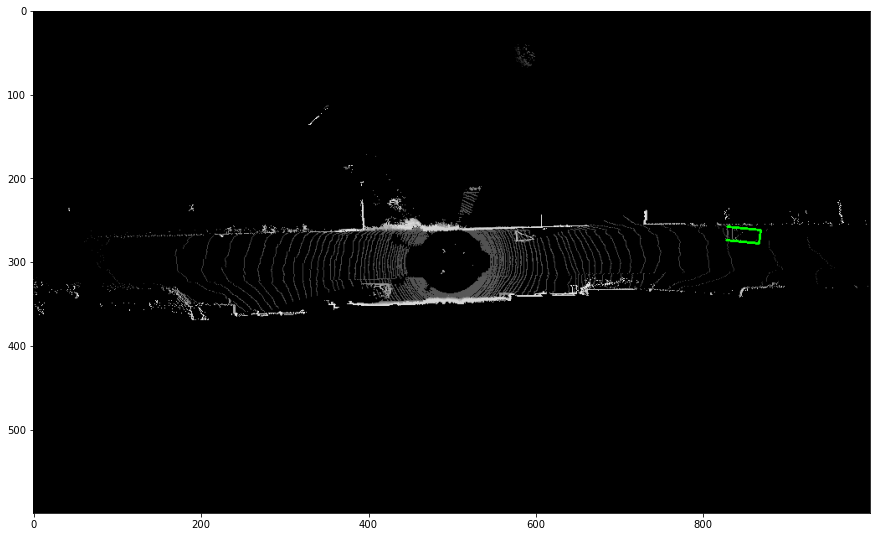

In [49]:
plt.rcParams["figure.figsize"] = (15,10)
plt.imshow(bev_map)